<a href="https://colab.research.google.com/github/rkh4m/CS4824_Capstone_Project/blob/main/Movie_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

DATA_PATH = "Train.csv"
train_df = pd.read_csv(DATA_PATH, encoding="utf-8-sig")

print(f"Train shape: {train_df.shape}")
train_df.head()

Train shape: (40000, 2)


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


## Training data overview
This section inspects the class balance, text lengths, and missing values in the movie review training split.

### Schema and missing values
Understand the column types and presence of nulls before modeling.

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [5]:
missing_summary = train_df.isnull().mean().mul(100).round(2)
missing_summary.to_frame(name="percent_missing")

,percent_missing
text,0.0
label,0.0


### Class distribution
Check whether the dataset is balanced across sentiment labels.

In [6]:
label_counts = train_df['label'].value_counts().sort_index()
label_counts

,count
label,
0,20019
1,19981


/tmp/ipython-input-2581298822.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


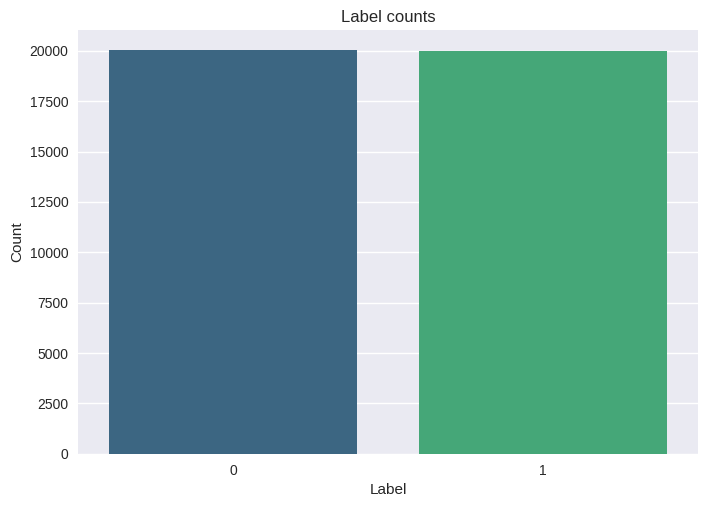

In [7]:
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Label counts")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### Review length analysis
Assess how long the reviews are to guide tokenization choices.

In [8]:
train_df['char_len'] = train_df['text'].str.len()
train_df['word_len'] = train_df['text'].str.split().str.len()

length_summary = train_df[['char_len', 'word_len']].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
length_summary

,char_len,word_len
count,40000.000000,40000.000000
mean,1310.293250,231.339250
std,988.358599,171.194123
min,32.000000,4.000000
10%,501.000000,90.000000
25%,698.000000,126.000000
50%,973.000000,173.000000
75%,1596.000000,282.000000
90%,2583.100000,452.000000
max,13704.000000,2470.000000


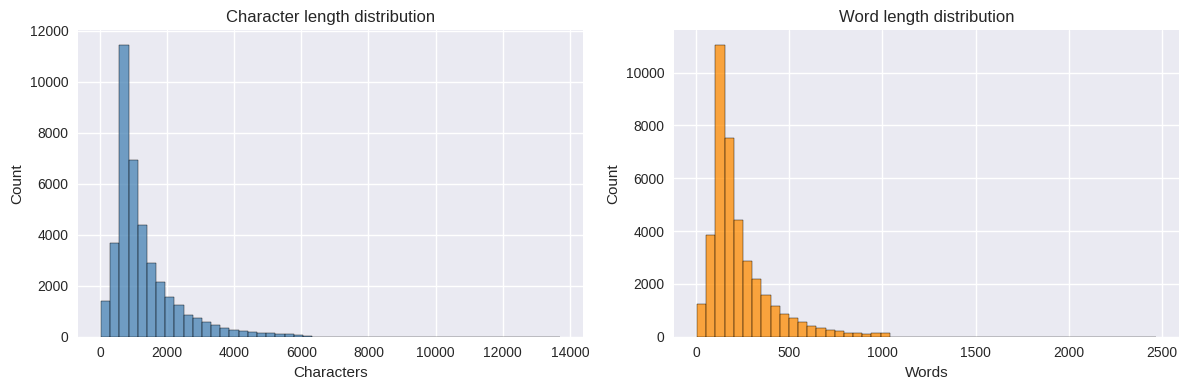

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(train_df['char_len'], bins=50, ax=axes[0], color="steelblue")
axes[0].set_title("Character length distribution")
axes[0].set_xlabel("Characters")

sns.histplot(train_df['word_len'], bins=50, ax=axes[1], color="darkorange")
axes[1].set_title("Word length distribution")
axes[1].set_xlabel("Words")

plt.tight_layout()
plt.show()

### Length by label
Compare how review length differs across sentiment classes.

In [10]:
length_by_label = train_df.groupby('label')[['char_len', 'word_len']].agg(['mean', 'median', 'max']).round(1)
length_by_label

char_len               word_len             
          mean median    max     mean median   max
label                                             
0       1292.5  973.0   8969    229.2  174.0  1522
1       1328.1  972.0  13704    233.5  173.0  2470

In [11]:
import torch
print(torch.cuda.is_available())

True


In [12]:
from datasets import load_dataset
import re

# Load our dataset
data_files = {"train": "Train.csv", "test": "Test.csv", "valid": "Valid.csv"}
dataset = load_dataset("csv", data_files=data_files)

print(dataset["train"][0])

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating valid split: 0 examples [00:00, ? examples/s]

{'text': 'I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.', 'label': 0}


In [13]:
from transformers import AutoTokenizer

# bert tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

# apply the tokenizer to the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# inspect tokenized samples
print(tokenized_datasets["train"][0])



Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

{'text': 'I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.', 'label': 0, 'input_ids': [101, 1045, 3473, 2039, 1006, 1038, 1012, 3551, 1007, 3666, 1998, 8295, 1996, 8505, 1288

In [26]:
from transformers import AutoModelForSequenceClassification, TrainingArguments

model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

print(model.config)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    report_to='none', # Directory for saving model checkpoints
    do_train=True,
    do_eval=True,
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=5e-5,              # Start with a small learning rate
    per_device_train_batch_size=16,  # Batch size per GPU
    per_device_eval_batch_size=16,
    num_train_epochs=3,              # Number of epochs
    weight_decay=0.01,               # Regularization
    save_total_limit=2,              # Limit checkpoints to save space
    load_best_model_at_end=True,     # Automatically load the best checkpoint
    logging_dir="./logs",            # Directory for logs
    logging_steps=100,               # Log every 100 steps
    fp16=True                        # Enable mixed precision for faster training
)

print(training_args)




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dtype": "float32",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devic

In [19]:
%pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.6 MB/s eta 0:00:00


In [27]:
from transformers import Trainer
from evaluate import load

# Load a metric (F1-score in this case)
metric = load("f1")

# Define a custom compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [28]:
from transformers import DataCollatorWithPadding
import os

os.environ["WANDB_DISABLED"] = "true"

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,                        # Pre-trained BERT model
    args=training_args,                 # Training arguments
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,        # Efficient batching
    compute_metrics=compute_metrics,     # Custom metric
)

# Start training
trainer.train()

/tmp/ipython-input-3939112893.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.219900,0.231079,0.916361
2,0.107900,0.290028,0.923960
3,0.055700,0.349284,0.925962


TrainOutput(global_step=7500, training_loss=0.16521793835957846, metrics={'train_runtime': 429.7982, 'train_samples_per_second': 279.201, 'train_steps_per_second': 17.45, 'total_flos': 1.57866633216e+16, 'train_loss': 0.16521793835957846, 'epoch': 3.0})

In [33]:
!pip install nbconvert